In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.options.display.max_columns = 100
%matplotlib inline

##### Загрузка и  разделение данных на датасеты

In [2]:
data = pd.read_csv('input/train.csv')

In [3]:
from sklearn.model_selection import train_test_split 

In [4]:
train, valid = train_test_split(data, test_size=0.3, random_state=42)

In [5]:
train.shape, valid.shape

((7000, 20), (3000, 20))

#### Train

In [6]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9069,14604,23,1.0,41.681380,22.796166,8.0,14,17.0,2015,0.075779,B,B,6,1437,3,NaN,0,2,B,88504.384965
2603,5621,23,3.0,163.495333,161.504222,12.0,5,3.0,1977,0.014073,B,B,2,475,0,NaN,0,0,B,207007.956663
7738,235,87,1.0,39.710131,19.538663,8.0,4,17.0,1986,0.100456,B,B,43,7227,0,NaN,1,6,A,182126.280899
1579,16258,48,3.0,96.056784,98.152802,1.0,15,1.0,2017,0.041125,B,B,46,9515,5,NaN,1,10,B,524365.550705
5058,10773,77,3.0,79.195825,44.421062,10.0,16,17.0,1984,0.298205,B,B,16,4048,3,NaN,1,3,B,322048.433990


#### Prepare train

Оценим визуально параметры плодщади и цены

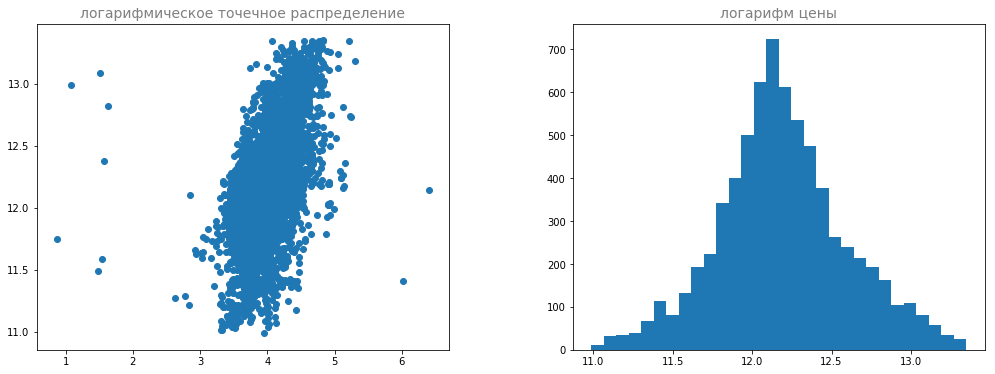

In [7]:
X = (train['Square'])
Y = (train['Price'])


fig, ax = plt.subplots(nrows=1, ncols=2)
ax1, ax2 = ax.flatten()

ax1.scatter(np.log(X), np.log(Y))
ax2.hist(np.log(train['Price']), bins=30)


ax1.set_title('логарифмическое точечное распределение', fontsize=14, color='#808080')
ax2.set_title('логарифм цены', fontsize=14, color='#808080')

fig.set_size_inches(17, 6)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

In [8]:
def get_cat_features(df):
    df = pd.get_dummies(df)
    return df

##### Предварительная обработка и заполнение недостающих данных в графе LifeSquare

Предварительная обработка выабросов и недостающих данных для LifeSquare, HouseYear, Rooms  не дало сколь либо ощутимых результатов для качества модели.
Преобразование же всех возможных признаков в дамми переменные и удаление второй связанной части для этих признаков несколько увеличило точность.

In [9]:
def prepare_data(df):
    df = get_cat_features(df)
    return df

In [10]:
train = prepare_data(train)


#### Prepare valid

In [11]:
valid = prepare_data(valid)

#### Model

##### В данном случае все свои усилия я сосредоточил на правильном подборе модели и ее параметров!

Для этого была использована технология Cross-validation для подбора параметров

Подбирались следующие параметры модели:

tuned_parameters = {'n_estimators': est_arr, 'max_depth': depth_arr, 'max_features' : max_features_arr} 

И использовал для этого 

GridSearchCV(RF(), tuned_parameters, cv=5, scoring=make_scorer(r2), n_jobs=-1, verbose=1) 

В результате были получены точные параметры для настройки модели 
которые дали вполне ощутимый прирост в качестве модели

n_estimators=821, max_depth=21, max_features=4

Исключение неполных данных Healthcare_1 и LifeSquare также положительно повлияло на качество предсказания
И хотя я понимаю что в LifeSquare есть данные которые можно использовать, я не смог наити способ, для улучшения модели.

In [12]:
fts =  ['Rooms','Square', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear',
       'Ecology_1', 
       'Social_1', 'Social_2', 'Social_3', 
       'Helthcare_2', 'Shops_1',
       'Ecology_2_A', 'Ecology_3_A', 'Shops_2_A'
       ]

In [13]:
from sklearn.ensemble import RandomForestRegressor as RF

In [14]:
model = RF(n_estimators=821, max_depth=21, max_features=4, random_state=42, n_jobs=-1)

In [15]:
model.fit(train.loc[:, fts], train['Price'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=21,
           max_features=4, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=821, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [16]:
pred_train = model.predict(train.loc[:, fts])

In [17]:
pred_valid = model.predict(valid.loc[:, fts])

In [18]:
pred_train

array([ 94270.24787356, 219230.73033487, 180378.34363121, ...,
       244103.98554732, 192936.04750416, 415445.16906286])

In [19]:
pred_valid

array([189145.05935377, 302353.50017237, 214127.12873234, ...,
       265849.2681253 , 107636.63443467, 257799.53181722])

In [20]:
from sklearn.metrics import r2_score as r2

In [21]:
r2(train['Price'], pred_train)

0.9622809213657694

In [22]:
r2(valid['Price'], pred_valid)

0.7341608738185098

#### Test


In [23]:
test = pd.read_csv('input/test.csv')


In [24]:
test = prepare_data(test)

In [25]:
pred_test = model.predict(test.loc[:, fts])

In [26]:
test['Price'] = pred_test

In [27]:
test.loc[:, ['Id', 'Price']].to_csv('PNovikov_predictions.csv', index=False)